In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("opinionated_rc")

df = pd.read_parquet("processed-plos-corpus.parquet")
df = df.astype({"publish_date": "datetime64[ns]"})

# Get dataframe of first row of each DOI group
df_doi_first = df.groupby("doi").first().reset_index()

print("N Unique DOIs:", len(df_doi_first))

print(df.columns)
df.sample(3)

N Unique DOIs: 3103
Index(['jats_xml_path', 'journal_name', 'journal_pmc_id', 'doi', 'full_title',
       'short_title', 'abstract', 'disciplines', 'repository_host',
       'repository_owner', 'repository_name', 'acknowledgement_statement',
       'funding_statement', 'funding_sources', 'publish_date', 'full_name',
       'email', 'affliation', 'roles', 'repository_stargazers_count',
       'repository_open_issues_count', 'repository_forks_count',
       'repository_most_recent_push_datetime', 'repository_license',
       'repository_data_cache_datetime', 'repository_languages'],
      dtype='object')


,jats_xml_path,journal_name,journal_pmc_id,doi,full_title,short_title,abstract,disciplines,repository_host,repository_owner,...,email,affliation,roles,repository_stargazers_count,repository_open_issues_count,repository_forks_count,repository_most_recent_push_datetime,repository_license,repository_data_cache_datetime,repository_languages
31873,/home/eva/miniforge-pypy3/envs/aligning-credit...,PLoS Comput Biol,ploscomp,10.1371/journal.pcbi.1010577,Fast and interpretable consensus clustering vi...,Fast and interpretable consensus clustering vi...,Consensus clustering has been widely used in b...,Physical sciences;Research and analysis method...,github,dataslingers,...,None,None,Conceptualization;Funding acquisition;Project ...,1,2,0,2023-03-09T21:58:16.000Z,None,2024-03-13T12:11:11.611108,R:21775;
26541,/home/eva/miniforge-pypy3/envs/aligning-credit...,PLoS ONE,plosone,10.1371/journal.pone.0292370,Future workspace needs flexibility and diversi...,A machine learning-driven behavioural analysis...,The future of workspace is significantly shape...,Earth sciences;Physical sciences;Medicine and ...,github,jp844,...,None,None,Resources,0,0,0,2023-08-26T19:14:40.000Z,None,2024-03-13T14:44:43.720075,Jupyter Notebook:43834;
9971,/home/eva/miniforge-pypy3/envs/aligning-credit...,PLoS ONE,plosone,10.1371/journal.pone.0225625,Semantic computational analysis of anticoagula...,Semantic computational analysis of anticoagula...,Atrial fibrillation (AF) is the most common ar...,Medicine and health sciences;Research and anal...,github,cogstack,...,None,None,Supervision;Writing – review & editing,4,1,2,2023-01-13T13:47:06.000Z,gpl-3.0,2024-03-13T13:18:13.409329,Python:28588;


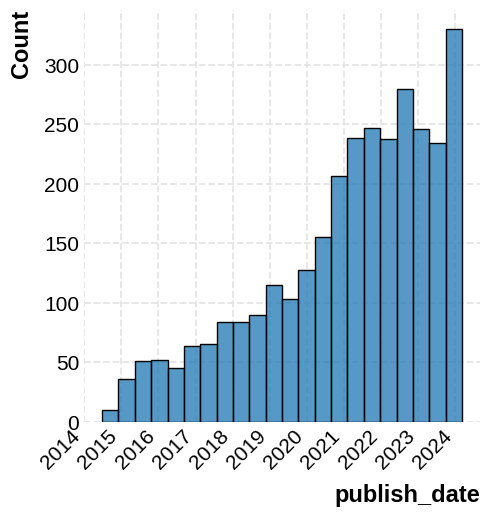

In [22]:
sns.displot(df_doi_first, x="publish_date")
_ = plt.xticks(rotation=45, ha="right")

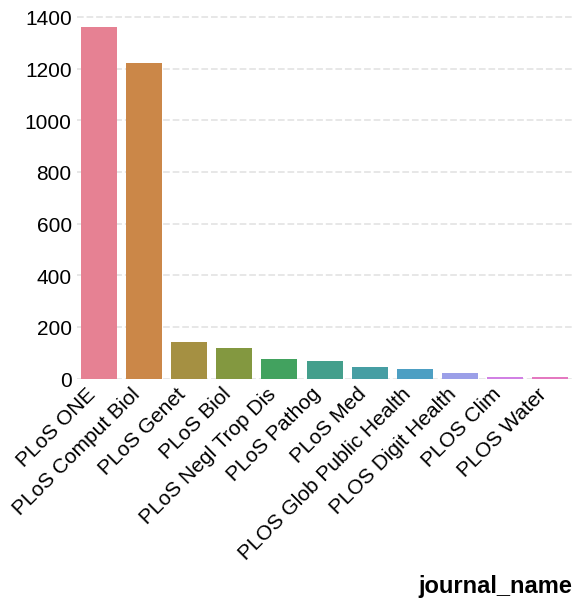

In [23]:
# Get counts of each journal name and sort by count
journal_counts = (
    df_doi_first["journal_name"].value_counts().sort_values(ascending=False)
)
sns.barplot(y=journal_counts.values, x=journal_counts.index, hue=journal_counts.index)
_ = plt.xticks(rotation=45, ha="right")

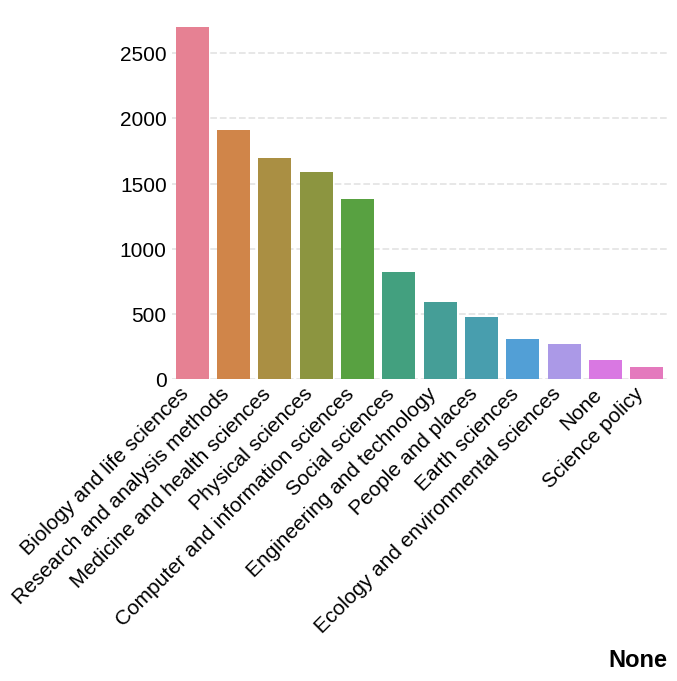

In [24]:
# Process disciplines by splitting by ";"
disc_counts: dict[str, int] = {}
for disc in df_doi_first["disciplines"]:
    if disc is None:
        disc_counts["None"] = disc_counts.get("None", 0) + 1
    else:
        for d in disc.split(";"):
            if d not in disc_counts:
                disc_counts[d] = 0
            disc_counts[d] += 1
discipline_counts = pd.Series(disc_counts).sort_values(ascending=False)


sns.barplot(
    x=discipline_counts.index, y=discipline_counts.values, hue=discipline_counts.index
)
_ = plt.xticks(rotation=45, ha="right")

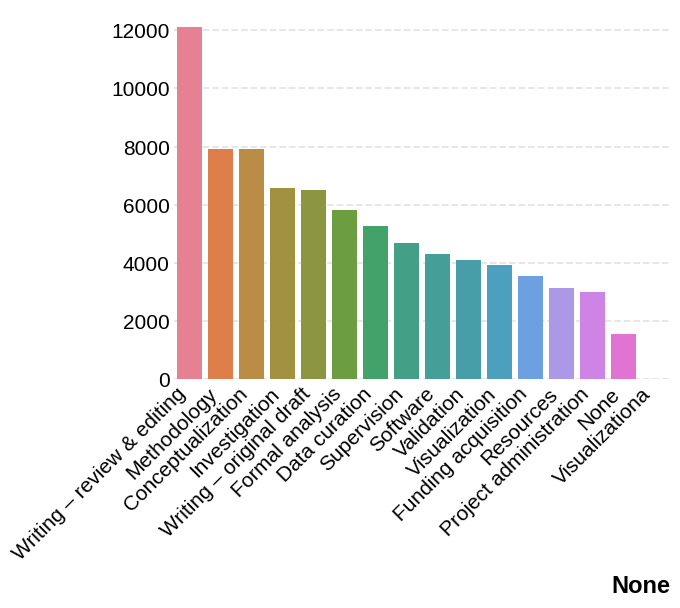

In [20]:
# Process roles by splitting by ";"
role_counts_dict = {}
for roles in df["roles"]:
    if roles is None:
        if "None" not in role_counts_dict:
            role_counts_dict["None"] = 0
        role_counts_dict["None"] += 1
    else:
        for r in roles.split(";"):
            if r not in role_counts_dict:
                role_counts_dict[r] = 0
            role_counts_dict[r] += 1
role_counts = pd.Series(role_counts_dict).sort_values(ascending=False)
sns.barplot(x=role_counts.index, y=role_counts.values, hue=role_counts.index)
_ = plt.xticks(rotation=45, ha="right")